In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from os.path import join
from tqdm.notebook import tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader


input_path = r'/content/planttraits2024'
remove_outliers = True # remove outliers from auxilary data
aux_columns_tresholds = [10, 1e3, 100, 5e4, 100, 3e5] # rows with values above these are considered to be incorrect
im_size = (224, 224)
trn_size = 50000
batch_size = 16
lr = 1e-3
mean, std = [0.3829, 0.3937, 0.2855], [0.2317, 0.2292, 0.2134]
num_aux_cols = 163
output_dim = 6
num_epochs = 12

#### Installing additional packages

In [ ]:
!pip install -q timm lightning torchmetrics tbparse
!python -m pip install git+https://github.com/lessw2020/Ranger21.git
clear_output()


import timm
import ranger21
import torchmetrics
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

#### DataSet class with image and auxilary data

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, img_folder, ids, aux_info, labels = None, idx_start = 0, idx_end = -1,\
                 transform = transforms.ToTensor(), is_test = False):
        if not is_test:
            self.labels = labels.values if ((idx_start == 0) and (idx_end == -1)) else labels.values[idx_start:idx_end]
        self.ids = ids.values if ((idx_start == 0) and (idx_end == -1)) else ids.values[idx_start:idx_end]
        self.aux_info = aux_info.values if ((idx_start == 0) and (idx_end == -1)) else aux_info.values[idx_start:idx_end]

        self.filenames = []

        for i in range(len(self.ids)):
            self.filenames.append(join(img_folder, f'{self.ids[i]}.jpeg'))

        self.transform = transform
        if not is_test:
            self.labels = torch.Tensor(self.labels)
        self.aux_info = torch.Tensor(self.aux_info)
        self.is_test = is_test
    def __len__(self):        return len(self.filenames)
    def __getitem__(self, idx):
        img = Image.open(self.filenames[idx])
        img.load()
        if self.is_test:
            return self.transform(img), self.aux_info[idx]
        else:
            return self.transform(img), self.aux_info[idx], self.labels[idx]

#### Removing to high values from auxilary data

In [ ]:
df = pd.read_csv(join(input_path, 'train.csv'))

feature_cols = [col for col in df.columns if ( col[0] == 'X' and 'mean' in col) ]

if remove_outliers:
    # tr = [10, 1e6, 4e3, 0.5e7, 1e5, 2e6]

    to_remove = []
    for i in range(len(feature_cols)):
        idx = np.where(df[feature_cols[i]] > aux_columns_tresholds[i])[0]
        to_remove += list(idx)
    # print(list(idx))
    to_remove = list(set(to_remove))
    to_remove.sort()
    for idx in to_remove[::-1]:
        df = df.drop(idx)
print(len(df))

55313


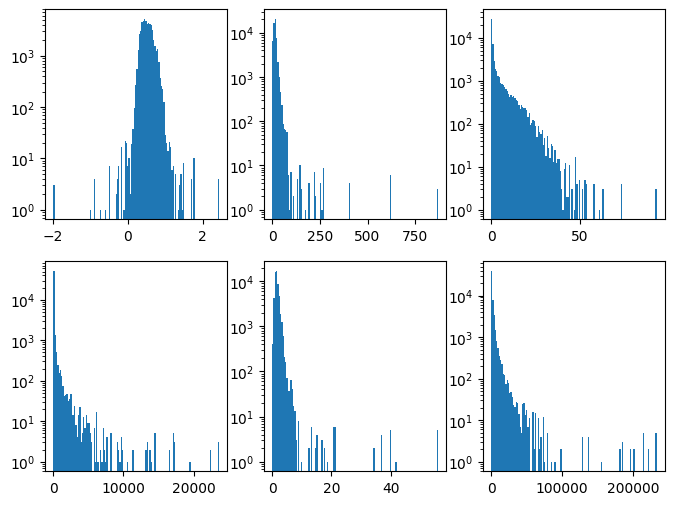

In [ ]:
def to01(x):
    min_, max_ = np.min(x), np.max(x)
    return (x - min_) / (max_ - min_)
fig = plt.figure(figsize = (8, 6))
for i in range(6):
    fig.add_subplot(2, 3, i + 1)
    # df[feature_cols[i]] = to01(df[feature_cols[i]].values)
    plt.hist(df[feature_cols[i]], bins = 128)
    plt.yscale('log')

#### Dataloaders initialization

In [ ]:
feature_cols = [col for col in df.columns if ( col[0] == 'X' and 'mean' in col) ]
std_cols = [col for col in df.columns if ( col[0] == 'X' and 'sd' in col) ]
aux_cols = list(set(df.columns) - set(feature_cols) - set(std_cols) - {'id'})

ids = df['id']
aux_info = df[aux_cols]
labels = df[feature_cols]

aux_mean, aux_std = aux_info.mean(), aux_info.std()
aux_info = (aux_info - aux_mean) / aux_std

labels_mean, labels_std = labels.mean(), labels.std()
labels = (labels - labels_mean) / labels_std

preprocessing = [
    # v2.ToTensor(),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Resize(im_size, antialias = True),
]
augmentation = [
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomRotation(90),
    v2.RandomResizedCrop(size=im_size, antialias=True,\
                         scale=(0.2, 1.0), ratio=(0.9, 1.1)),
    v2.ColorJitter(brightness = 0.7, contrast = 0.7),
]

normalization = [transforms.Normalize(mean = mean,\
                            std = std)]

trn_ds = ImgDataset(join(input_path, 'train_images'),ids, aux_info, labels,\
                    0, trn_size, transform = v2.Compose(preprocessing + augmentation + normalization))
val_ds = ImgDataset(join(input_path, 'train_images'), ids, aux_info, labels,\
                    trn_size, len(labels), transform = v2.Compose(preprocessing + normalization))


loaders={'trn' : DataLoader(trn_ds, batch_size = batch_size, shuffle = True, num_workers = 3, drop_last = True),\
         'val' : DataLoader(val_ds, batch_size = batch_size, shuffle = False, num_workers = 3, drop_last = True)}

tensor(-1.7177) tensor(0.1309)


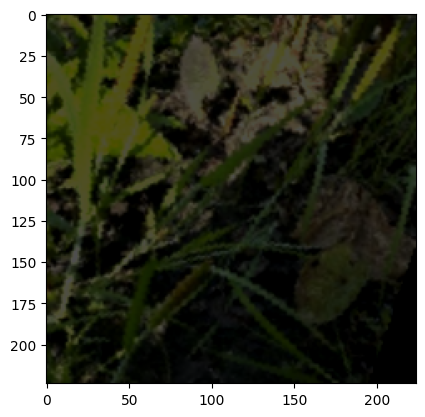

In [ ]:
X, a, y = trn_ds[np.random.randint(1000)]
print(X.min(), X.max())
mean = torch.Tensor(mean)
std = torch.Tensor(std)
X = X * std.view(3,1,1) + mean.view(3,1,1)
plt.imshow((X).permute(1, 2, 0) )

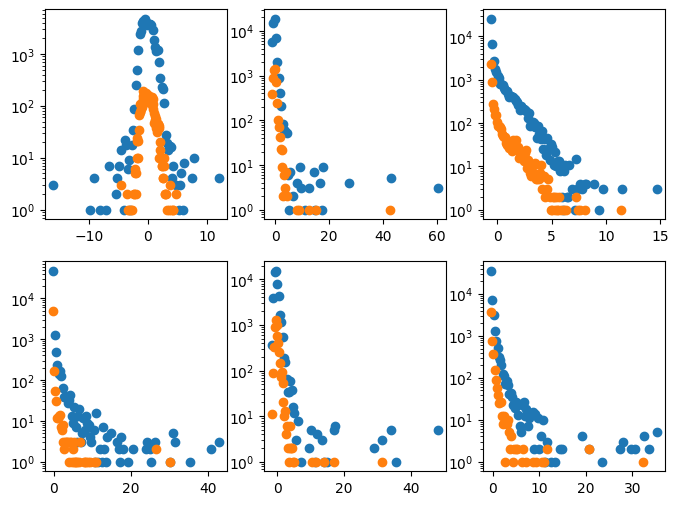

In [ ]:
fig = plt.figure(figsize = (8, 6))
for i in range(6):
    fig.add_subplot(2, 3, i + 1)

    th, tb = np.histogram(trn_ds.labels[:, i], bins = 128)
    plt.scatter(tb[:-1], th)

    vh, vb = np.histogram(val_ds.labels[:, i], bins = 128)
    plt.scatter(vb[:-1], vh)
    plt.yscale('log')

#### Lightning module for training

In [ ]:
class Lit(L.LightningModule):
  def __init__(self, model,
               exp_name = 'baseline',\
               other_params = {},\
               crit = nn.MSELoss(), opt_class = optim.AdamW,\
               opt_kwargs = {'lr' : 1e-3},\
               metric_class = torchmetrics.MeanSquaredError,
               metric_kwargs = {}):
    super().__init__()
    # self.logdir = exp_name

    # self.save_hyperparameters()

    self.model = model
    self.criterion = crit
    self.opt_class = opt_class
    self.opt_kwargs = opt_kwargs

    self.trn_metric = metric_class(**metric_kwargs)#.to(self.device)#task = 'multiclass', num_classes = 10)
    self.val_metric = metric_class(**metric_kwargs)#.to(self.device)#task = 'multiclass', num_classes = 10)



  def configure_optimizers(self):
    optimizer = self.opt_class(self.model.parameters(), **self.opt_kwargs)
    return optimizer


  def training_step(self, batch, batch_idx):
    X, aux, y = batch
    y_pred = self.model(X, aux)
    loss = self.criterion(y_pred, y)

    self.trn_metric.update(y_pred, y)
    self.log('trn_loss', loss.detach().item())

    return loss


  def validation_step(self, batch, batch_idx):
    X, aux, y = batch
    with torch.no_grad():
      y_pred = self.model(X, aux)
      loss = self.criterion(y_pred, y)

    self.val_metric.update(y_pred, y)
    self.log('val_loss', loss.detach().item())

    return loss


  def on_train_epoch_end(self):
    m = self.trn_metric.compute()
    print('trn:', m)
    self.log('trn_metric', m)
    self.trn_metric.reset()


  def on_validation_epoch_end(self):
    m = self.val_metric.compute()
    print('val:', m)
    self.log('val_metric', m)
    self.val_metric.reset()

    torch.save(self.model.state_dict(), '/kaggle/working/backup')

#### Model definition with Image processing model (ConvFormer S18) and auxilary data processing (MLP)

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class MyModel(nn.Module):
    def __init__(self, img_model_name, inp_dim, out_dim):
        super().__init__()
        self.model_img = timm.create_model(img_model_name,\
                                           in_chans = 3, pretrained = True)
        self.model_img.head.fc.fc2 = Identity()
        last_dim = 2048

        self.model_tab = nn.Sequential(
            nn.Linear(inp_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.LeakyReLU()
        )
        self.regressor = nn.Sequential(
            nn.Linear(last_dim + 64, out_dim)
        )

    def forward(self, img, aux_data):
        x1 = self.model_img(img)
        x2 = self.model_tab(aux_data)
        x = torch.cat((x1, x2), dim = 1)
        x = self.regressor(x)
        return x

#### Custom loss-functions

In [ ]:
from torchmetrics.functional import r2_score
class R2Loss(nn.Module):
    def __init__(self, eps = 1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, y_true, y_pred):
        y_pred = y_pred.type(torch.FloatTensor)
        y_true = y_true.type(torch.FloatTensor)
        return 1.0 - r2_score(y_true, y_pred)


class XSigmoidLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(2 * ey_t / (1 + torch.exp(-ey_t)) - ey_t)

In [ ]:
img = torch.randn((batch_size, 3) + im_size)
aux = torch.randn(batch_size, num_aux_cols)


model = MyModel('convformer_s18.sail_in22k_ft_in1k', num_aux_cols, output_dim)
with torch.no_grad():
    print(model(img, aux).shape)

model.safetensors:   0%|          | 0.00/107M [00:00<?, ?B/s]

torch.Size([16, 6])


In [ ]:
print(*timm.list_models('*convformer_s18*', pretrained = True), sep = '\n')

convformer_s18.sail_in1k
convformer_s18.sail_in1k_384
convformer_s18.sail_in22k
convformer_s18.sail_in22k_ft_in1k
convformer_s18.sail_in22k_ft_in1k_384


In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

#### training model

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor = "val_metric")
lit_model = Lit(model,crit=XSigmoidLoss(),\
                metric_class = torchmetrics.R2Score,\
                metric_kwargs = {'num_outputs' : output_dim},\
               opt_class = ranger21.Ranger21,\
               opt_kwargs = {'lr' : lr, 'num_epochs' : num_epochs,\
                      'num_batches_per_epoch' : len(loaders['trn'])}
               )
model_name = 'co18'

trainer = L.Trainer(max_epochs = num_epochs,\
                    logger = TensorBoardLogger(save_dir = f"/kaggle/working/lightning_logs/{model_name}"),\
                    log_every_n_steps = 5,\
                   callbacks=[checkpoint_callback])

In [ ]:
trainer.fit(model = lit_model,\
            train_dataloaders = loaders['trn'],\
            val_dataloaders = loaders['val'])

2024-09-01 16:35:03.906943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 16:35:03.907062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 16:35:04.033560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | model      | MyModel      | 24.8 M | train
1 | criterion  | XSigmoidLoss | 0      | train
2 | trn_metric | R2Score      | 0      | train
3 | val_metric | R2Score      | 0      | train
--------------------

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 12 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 27000 of 37500
warm down will decay until 3e-05 lr


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val: tensor(-0.3057, device='cuda:0')


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 248

** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1242, device='cuda:0')
trn: tensor(0.0935, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1468, device='cuda:0')
trn: tensor(0.1120, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1500, device='cuda:0')
trn: tensor(0.1234, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1568, device='cuda:0')
trn: tensor(0.1298, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1590, device='cuda:0')
trn: tensor(0.1340, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1590, device='cuda:0')
trn: tensor(0.1386, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1669, device='cuda:0')
trn: tensor(0.1433, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1683, device='cuda:0')
trn: tensor(0.1459, device='cuda:0')

** Ranger21 update: Warmdown starting now.  Current iteration = 27000....



Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1735, device='cuda:0')
trn: tensor(0.1489, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1829, device='cuda:0')
trn: tensor(0.1591, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1874, device='cuda:0')
trn: tensor(0.1712, device='cuda:0')
error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

val: tensor(0.1921, device='cuda:0')
trn: tensor(0.1824, device='cuda:0')


#### Saving logs

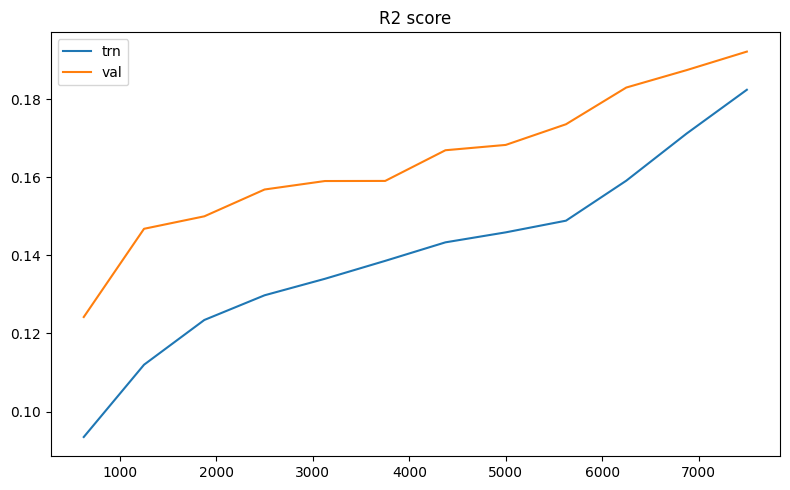

In [ ]:
from tbparse import SummaryReader

log_dir = trainer.logger.experiment.get_logdir()  # lightning_logs/version_x

reader = SummaryReader(log_dir, pivot=True)
train_df = reader.scalars
train_df.head()

fig=plt.figure(figsize=(8, 5))

def drop_nan(df, tag):
    return df[~df[tag].isna()].loc[:, tag]

train_df.to_csv('training_logs.csv')

plt.title('R2 score')
plt.plot(drop_nan(train_df,tag='trn_metric'),label='trn')
plt.plot(drop_nan(train_df,tag='val_metric'),label='val')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

#### Test predictions

In [ ]:
model = trainer.model.model
model.eval();

In [ ]:
model = model.to('cuda:0')

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df_tst = pd.read_csv(join(input_path, 'test.csv'))

ids = df_tst['id']
aux_info_tst = df_tst[aux_cols]
# labels = df_tst[feature_cols]
aux_info_tst = (aux_info_tst - aux_mean) / aux_std
# labels = (labels - labels_mean) / labels_std
print(len(ids[:]))
tst_ds = ImgDataset(join(input_path, 'test_images'), ids, aux_info_tst,\
                    len(aux_info_tst), is_test = True,\
                    transform = transforms.Compose(preprocessing + normalization))

6545
